In [1]:
import os
import pandas as pd
import numpy as np
import plotnine as p9

In [31]:
import plotnine as p9

def create_mosaic_plot(data, metric):
    """
    Create a mosaic plot using plotnine with faceting on the 'dataset' column.

    :param data: DataFrame with columns 'reduction_name', 'score_key', 'mean_auc', and 'dataset'.
    :return: The plotnine plot object.
    """
    # Create the plot
    plot = (p9.ggplot(data, p9.aes(x='reduction_name', y='score_key', fill=metric)) +
            p9.geom_tile() +
            p9.theme_bw(base_size=11) +
            p9.facet_grid(' ~ dataset') +
            p9.scale_fill_cmap(limits=(0.5, 1), cmap_name='viridis') +
            p9.geom_text(p9.aes(label='mean_auc'), size=10, color='white', fontweight='bold') +
            p9.theme(figure_size=(9, 6), 
                     axis_text_x=p9.element_text(angle=90, size=11),
                     strip_text_x=p9.element_text(size=11),
                     strip_background=p9.element_rect(colour="black", fill="#fdfff4"),
                     legend_text=p9.element_text(size=11),
                     axis_text_y=p9.element_text(size=11)) +
            p9.labs(x='', y='', fill=metric))

    return plot

# Example usage:
# Assuming 'results' is your DataFrame with the required columns
# plot = create_mosaic_plot_with_facets(results)
# plot.draw()
# If you're in a Jupyter notebook, displaying 'plot' will show the plot


Load Results and Concat

In [2]:
# list output files
file_paths = os.listdir(os.path.join('data', 'results'))
# keep only .csv files
results = [pd.read_csv(os.path.join('data', 'results', p)) for p in file_paths if p.endswith('.csv')]

In [3]:
results = pd.concat(results)

In [4]:
results['mean_auc'] = results.groupby(['reduction_name', 'dataset', 'score_key'])['auroc'].transform('median')
results['mean_f1'] = results.groupby(['reduction_name', 'dataset', 'score_key'])['f1_score'].transform('median')
results = results[['reduction_name', 'score_key', 'mean_auc', 'mean_f1', 'dataset']].drop_duplicates()

In [5]:
remap_dict = {'lr_means':'CellPhoneDB',
              'expr_prod':'Product',
              'lr_logfc': 'logFC',
              'lrscore': 'SingleCellSignalR',
              'lr_probs': 'CellChat',
              'magnitude_rank':'Rank_Aggregate',
              'inter_score': 'scSeqComm',
              'lr_gmeans': 'Geometric Mean',
              }
# Prettify names
results['score_key'] = results['score_key'].map(remap_dict)
results['reduction_name'] = results['reduction_name'].replace({"mofa":"MOFA+", 'tensor':"Tensor-cell2cell"})

In [6]:
# mean rank per Method
score_avg = results.groupby(['score_key', 'reduction_name'])[['mean_auc', 'mean_f1']].agg('mean')
score_avg['dataset'] = "Score Average"
results = pd.concat([results, score_avg.reset_index()])
results['mean_auc'] = results['mean_auc'].round(2)
results['mean_f1'] = results['mean_f1'].round(2)

In [7]:
# to title
results['dataset'] = results['dataset'].replace({'Score Average': 'Average'})
results['dataset'] = pd.Categorical(results['dataset'], categories=['carraro', 'habermann', 'kuppe', 'velmeshev', 'reichart', 'Average'])
results['dataset'] = results['dataset'].str.title()

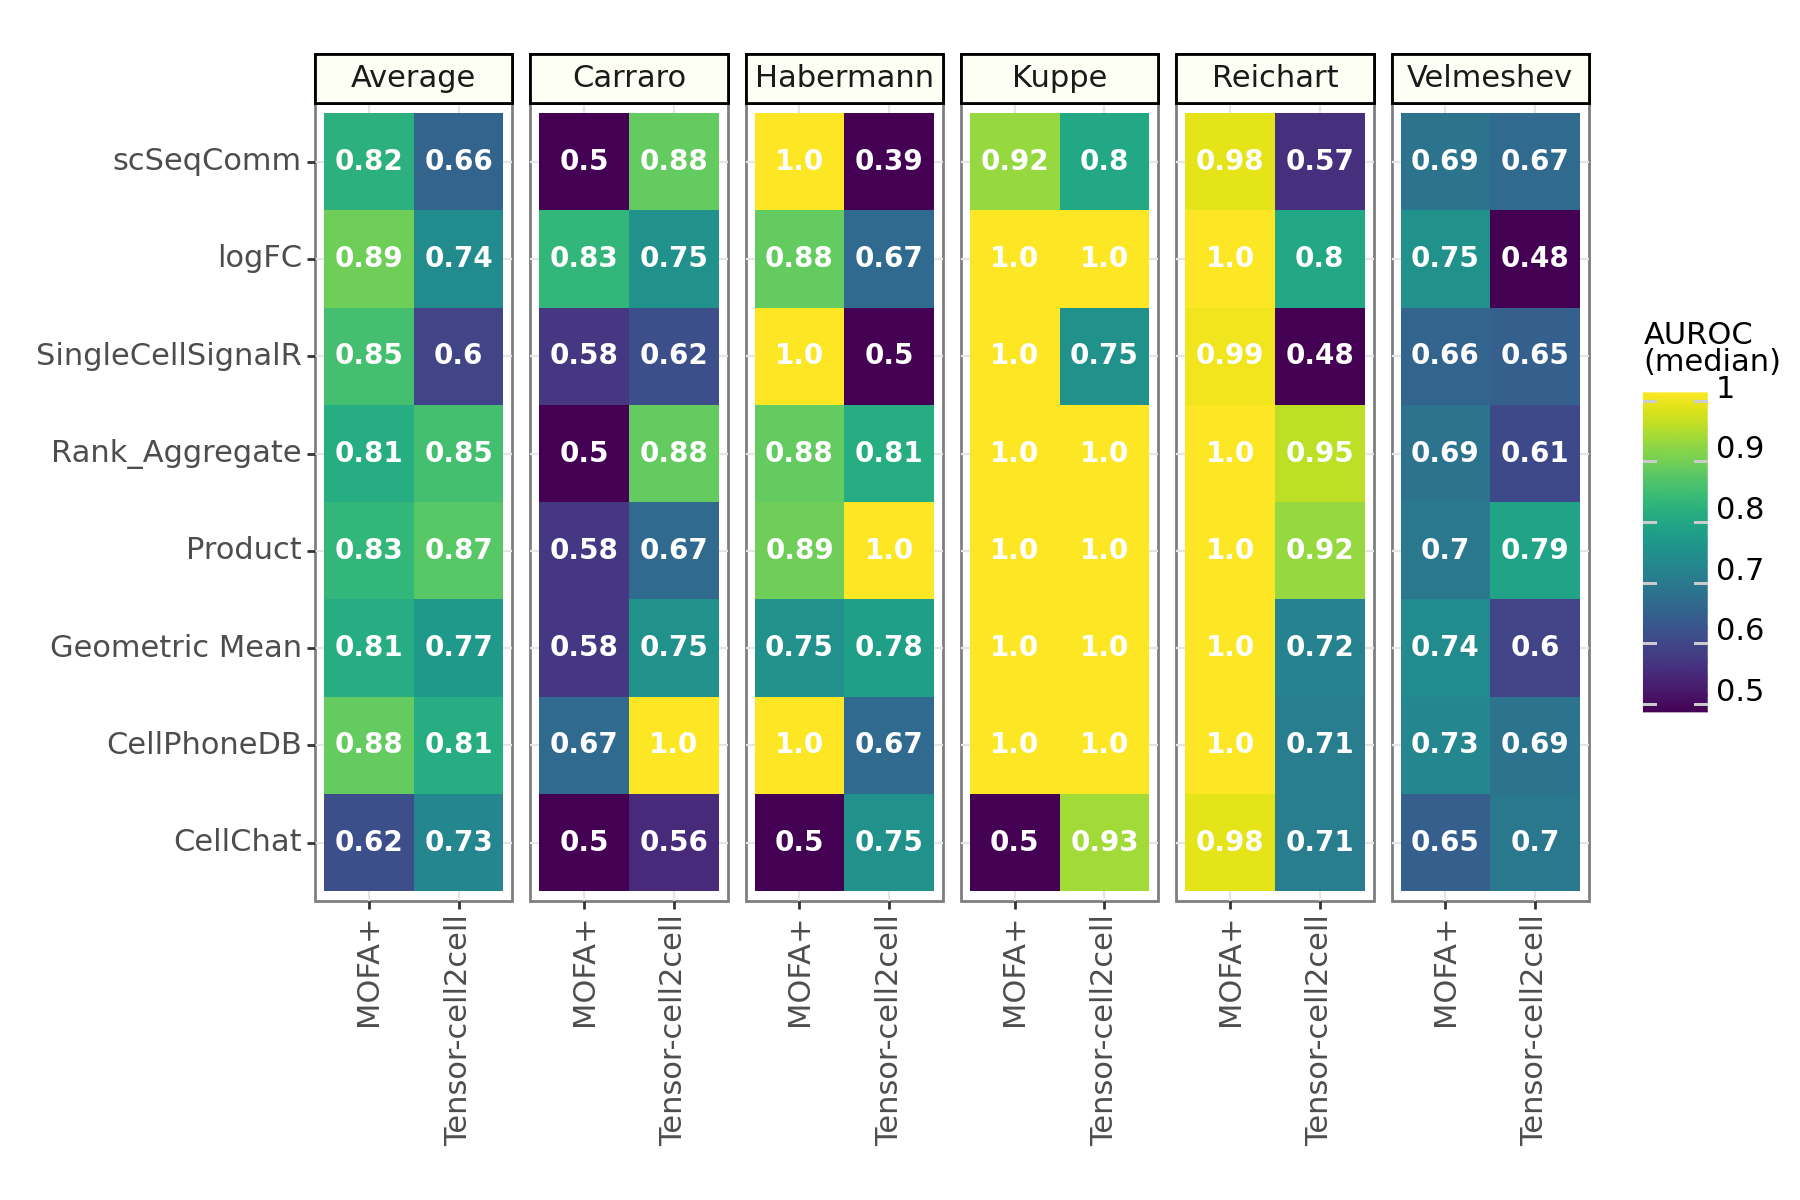

<Figure Size: (900 x 600)>

In [8]:
## mosaic plot
# order alphabetically
p9.ggplot(results, p9.aes(x='reduction_name', y='score_key', fill='mean_auc')) + \
    p9.geom_tile() + \
    p9.theme_bw(base_size=11) + \
    p9.facet_grid(' ~ dataset') + \
    p9.scale_fill_cmap(limits=(0.5, 1), cmap_name='viridis') + \
    p9.geom_text(p9.aes(label='mean_auc'), size=10, color='white', fontweight='bold') + \
    p9.theme(figure_size=(9, 6), axis_text_x=p9.element_text(angle=90, size=11),
             strip_text_x=p9.element_text(size=11),
            strip_background=p9.element_rect(colour="black", fill="#fdfff4"),
            legend_text=p9.element_text(size=11),
            axis_text_y=p9.element_text(size=11),
             ) + \
    p9.labs(x='', y='', fill='AUROC\n(median)\n')

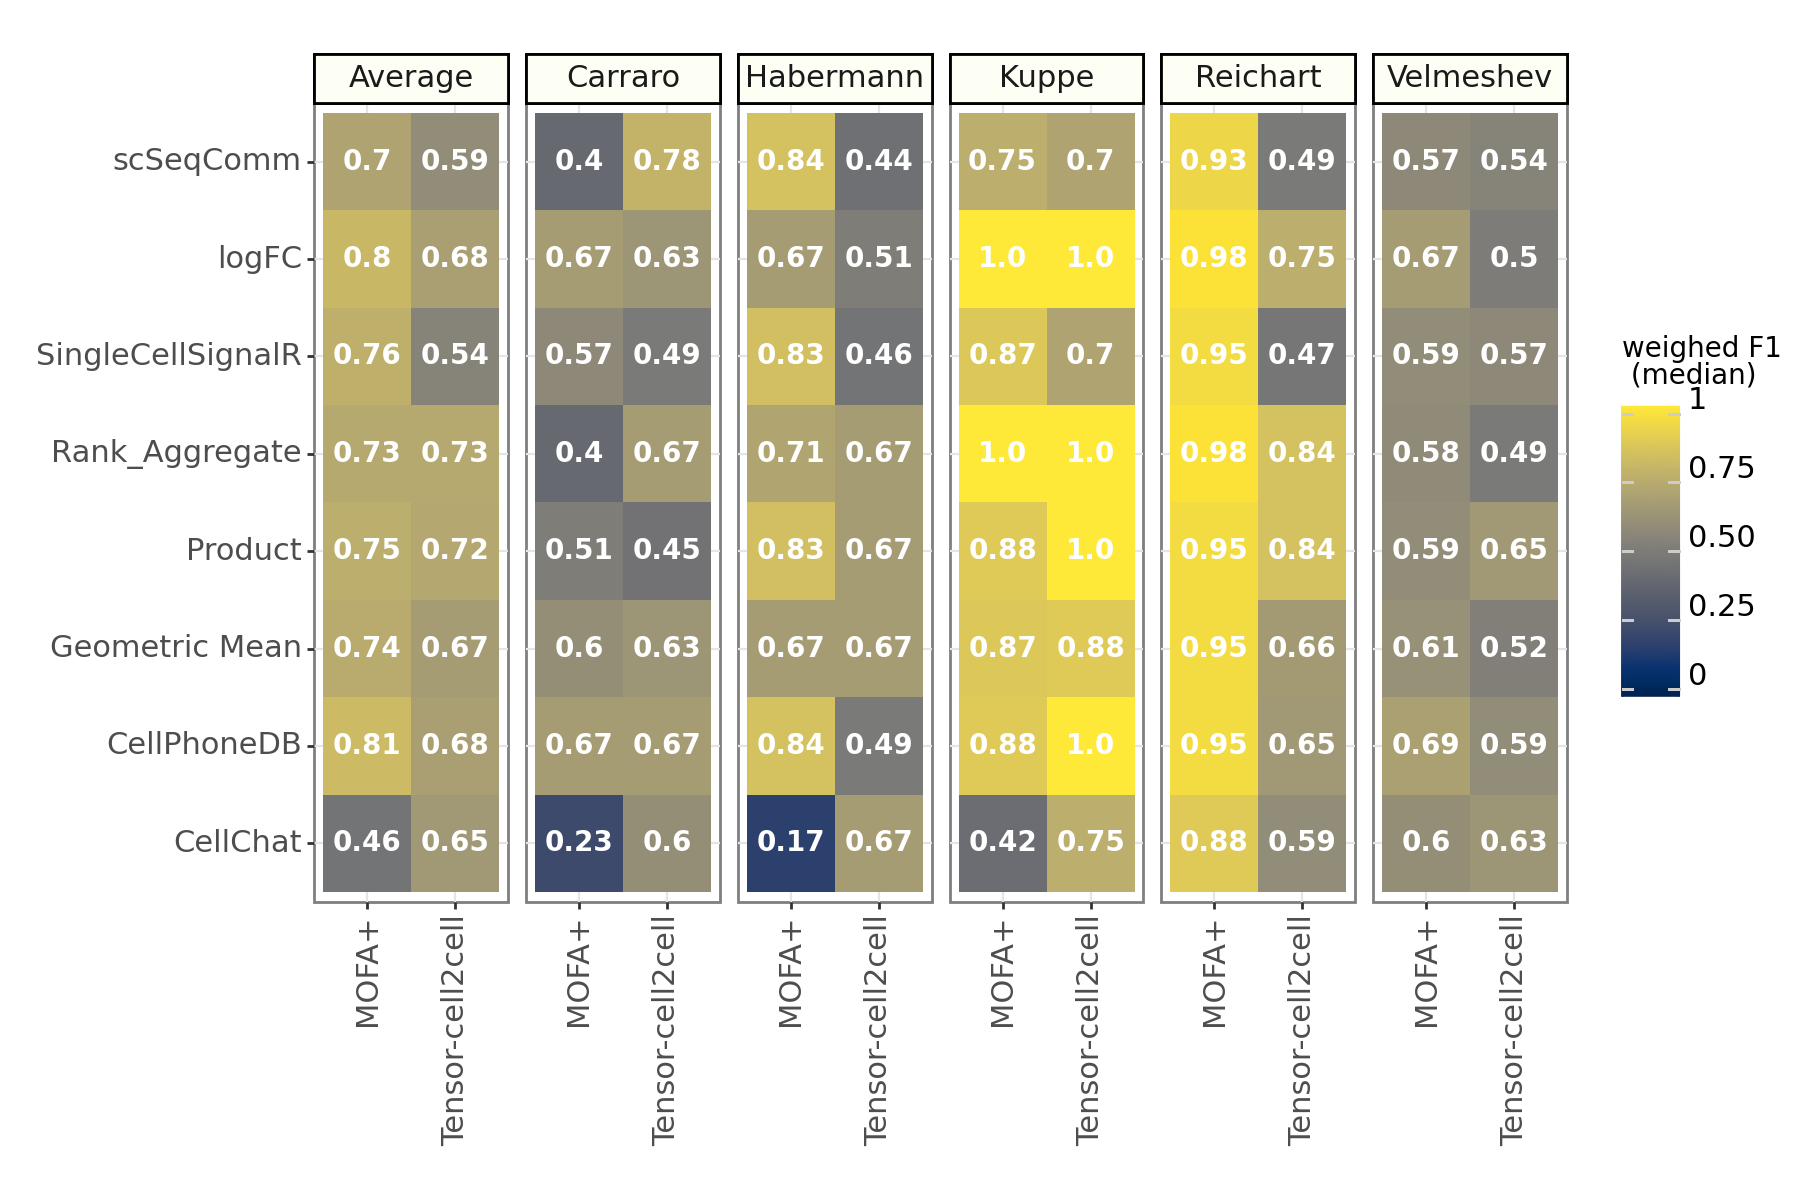

<Figure Size: (900 x 600)>

In [9]:
## mosaic plot
# order alphabetically
p9.ggplot(results, p9.aes(x='reduction_name', y='score_key', fill='mean_f1')) + \
    p9.geom_tile() + \
    p9.theme_bw(base_size=10) + \
    p9.facet_grid(' ~ dataset') + \
    p9.scale_fill_cmap(limits=(0, 1), cmap_name='cividis') + \
    p9.geom_text(p9.aes(label='mean_f1'), size=10, color='white', fontweight='bold') + \
    p9.theme(figure_size=(9, 6), axis_text_x=p9.element_text(angle=90, size=11),
             strip_text_x=p9.element_text(size=11),
            strip_background=p9.element_rect(colour="black", fill="#fdfff4"),
            legend_text=p9.element_text(size=11),
            axis_text_y=p9.element_text(size=11),
             ) + \
    p9.labs(x='', y='', fill='weighed F1\n (median) \n')

In [10]:
import scanpy as sc

In [11]:
adata = sc.read_h5ad("data/results/carraro_dimred.h5ad")

In [12]:
adata.uns['mofa_res']['X'].keys()

dict_keys(['expr_prod', 'inter_score', 'lr_gmeans', 'lr_logfc', 'lr_means', 'lr_probs', 'lrscore', 'magnitude_rank'])